# Sentiment Analysis - Twitter

In [1]:
from __future__ import print_function
%matplotlib inline

from IPython.display import Image, display
from io import BytesIO
import matplotlib.pyplot as plt

#import nltk
#from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer

#import numpy as numpy
import random
#import pickle
from collections import Counter
import codecs
import tensorflow as tf
import np
import time

import os
from os.path import join, exists

import pandas as pd
import pydot_ng as pydot
import graphviz
from ggplot import *

from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Dropout, Flatten, LSTM
from keras.optimizers import RMSprop, Adam, SGD, Adagrad

#nltk.download('punkt')
#nltk.download('wordnet')
#totalLinesToRead = 100
#lemmatizer = WordNetLemmatizer()

/usr/local/lib/python2.7/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python2.7/dist-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


# Data load

The first step when building machine learning model is getting your data into the proper form to feed into the model. 


In [2]:
with open('./data/twitter-train-pos', 'r') as f:
    positive_train_txt = f.read()
with open('./data/twitter-train-neg', 'r') as f:
    negative_train_txt = f.read()

In [3]:
print("The positive data size: {}".format(len(positive_train_txt)))
print("The negative data size: {}".format(len(negative_train_txt)))

The positive data size: 22403729
The negative data size: 22157551


## Basic prediction
Let's assume we will say to all data positive.


In [4]:
print("Basic/Benchmark Accuracy: " + str(float(len(positive_train_txt)) / (len(positive_train_txt) + len(negative_train_txt))))

Basic/Benchmark Accuracy: 0.502762241121


# Download GloVe


In [5]:
data_folder = './datasets'
glove = 'glove.6B'
glove_filename = glove + '.zip'
glove_url = 'http://nlp.stanford.edu/data/' + glove_filename
embedding_dim = 300
glove_loc = join(data_folder, glove_filename)

if not exists(glove_loc):
    print('Download %s' % glove_filename)
    get_file(glove_filename, glove_url, cache_dir='.', extract=True)

glove_filename = os.path.join(data_folder, glove + '.' + str(embedding_dim) + 'd.txt')

embeddings = {}

print('Extract %s' % glove_filename)
with open(glove_filename, 'r') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings[word] = embedding
        
print('Embeddings size: %d' % len(embeddings))

Extract ./datasets/glove.6B.300d.txt
Embeddings size: 400000


# Data preprocessing

First, let's remove all punctuation. Then get all the text without the newlines and split it into individual words.

In [6]:
from string import punctuation

def get_reviews(text):
    #all_text = ''.join([c for c in text if c not in punctuation])
    reviews = text.split('\n')
    return reviews[:10000] # TAKE first 1000 to make it fast

positive_train = get_reviews(positive_train_txt)
negative_train = get_reviews(negative_train_txt)

positive_label = np.full((len(positive_train), 2), [1, 0])
negative_label = np.full((len(negative_train), 2), [0, 1])

train = np.concatenate((positive_train, negative_train), axis=0)
labels = np.concatenate((positive_label, negative_label), axis=0)

# shuffle
c = np.c_[train.reshape(len(train), -1), labels.reshape(len(labels), -1)]
np.random.shuffle(c)

train = c[:, :train.size//len(train)].reshape(train.shape)
labels = c[:, train.size//len(train):].reshape(labels.shape)

del c
del positive_label
del negative_label

print("Train shape: \t\t{}".format(train.shape))
print("Label shape: \t\t{}".format(labels.shape))

Train shape: 		(20000,)
Label shape: 		(20000, 2)


## Encoding the words
Create dictinaries that map the words in the vocaulary to integers. Then we can convert each of our reviews into integers sos they can be passed into the network.

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train)
train_ints = tokenizer.texts_to_sequences(train)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 31166 unique tokens.


In [8]:
#word_index['dog']
#embeddings['dog']

#embedding_vector[876]
#[-1.1043e-01,  8
 
#print(tokenizer.texts_to_sequences("once upon a time once"))
#train

## Prepare Word Embeddings

In [9]:
from collections import defaultdict
NUM_WORDS = len(embeddings)
words_len = min(NUM_WORDS, len(word_index))
word_embedding_matrix = np.random.random((words_len + 1, embedding_dim))
k = 0
for word, i in word_index.items():
    if i >= NUM_WORDS:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector
        k += 1
        
del embeddings

In [10]:
print('Null word embeddings: %d' % (np.sum(np.sum(word_embedding_matrix, axis=1) == 0) - 1))
print('Found %d' % k)
print('Total: %d' % len(word_embedding_matrix))

Null word embeddings: -1
Found 16114
Total: 31167


## Sentence length

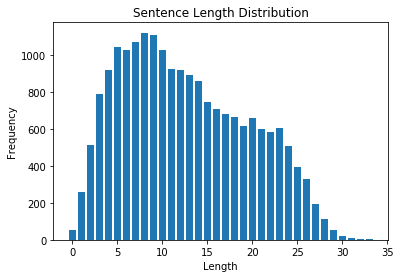

In [11]:
from collections import defaultdict

max_word_count_text = 0
text_count = defaultdict(int)
for sentence in train_ints:
    max_word_count_text = max(max_word_count_text, len(sentence))
    text_count[len(sentence)] += 1
    
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

ax.bar(range(len(text_count)), text_count.values())

plt.title("Sentence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [12]:
print('Max word sentence: %d' % max_word_count_text)

Max word sentence: 34


Some issues here. We seem to have one tweet with zero length. And, the maximum tweet length is way too many steps for our RNN. Let's truncate to 15 steps. For tweets shorter than 15, we'll pad with 0s. For tweets longer than 15, we can truncate them to the first 15 characters.

In [13]:
#train_ints = [train_ints[ii] for ii in non_zero_idx]
#labels = np.array([labels[ii] for ii in non_zero_idx])

Now, create an array features that contains the data we'll pass to the network. The data should come from review_ints, since we want to feed integers to the network. Each row should be 15 elements long. For reviews shorter than 15 words, left pad with 0s. For tweet longer than 15, use on the first 15 words as the feature vector.

In [14]:
seq_len = 15
features = sequence.pad_sequences(train_ints, maxlen = seq_len)

In [15]:

print('One sample')

print('Text: ')
print( train[1] )

print('Word sequence: ')
print( train_ints[1] )

print('Pad: ')
print( features[1] )

print('Label: ')
print( labels[1] )

del train

One sample
Text: 
Im enjoying my day off...drinking Earle Gray tea and watching American Psycho!
Word sequence: 
[53, 617, 6, 30, 81, 861, 9247, 9248, 761, 5, 150, 1286, 3915]
Pad: 
[   0    0   53  617    6   30   81  861 9247 9248  761    5  150 1286 3915]
Label: 
['1' '0']


# Training, Validation, Test

With our data in nice shape, we'll split it into training, validation, and test sets. Do not foget to shuffle it.

In [16]:
split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape)) 
print("Validation set: \t{}".format(val_x.shape))
print("Test set: \t\t{}".format(test_x.shape))

print("Train lable: \t\t{}".format(train_y.shape))


			Feature Shapes:
Train set: 		(16000, 15)
Validation set: 	(2000, 15)
Test set: 		(2000, 15)
Train lable: 		(16000, 2)


# Generate Lemmas 

## Create Sentiment Neural Network

In [18]:
def createModel(hidden_size, drop_size, output_activation):
    model = Sequential()

    model.add(Dense(hidden_size, activation='relu', input_dim = seq_len))
    
    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu'))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu'))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(2, activation=output_activation))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    return model




In [19]:
def createEmbeddedModel(hidden_size, drop_size):
    model = Sequential()
    
    model.add(Embedding(words_len + 1,
                     embedding_dim,
                     weights = [word_embedding_matrix],
                     input_length = seq_len,
                     trainable = False,
                     name = 'embedding'))
    if drop_size > 0.0:
        model.add(Dropout(drop_size))
        
    model.add(LSTM(seq_len, dropout=0.2, recurrent_dropout=0.2))
    
    model.add(Dense(hidden_size, activation='relu', input_dim = seq_len, name="hidden_1"))
    
    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu', name="hidden_2"))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu', name="hidden_3"))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))
        
    #model.add(Flatten())  # [[ [1, 2], [2, 2] ], ....]  -> [[ 1, 2, 2, 2], ....]

    model.add(Dense(2, activation='sigmoid', name="output"))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    return model

## Train model

In [20]:
batch_size = 20
epochs = 5

# 16000 -> 100, 100, 100

models = {}

#models['model_200_drop_0.1_softmax'] = createModel(200, 0.1, 'softmax')
#models['model_200_drop_0.1_sigmoid'] = createModel(200, 0.1, 'sigmoid')

#models['model_400_drop_0.1'] = createModel(400, 0.1)
#models['model_600_drop_0.1'] = createModel(600, 0.1)
#models['model_200_no_drop'] = createModel(200, 0)
#models['model_400_no_drop'] = createModel(400, 0)
#models['model_600_no_drop'] = createModel(600, 0)

models['model_15_embedded_drop_0.1_twitter_small_5epochs'] = createEmbeddedModel(15, 0)

results = []
for name, model in models.items():  
    start_time = time.time()
    print('')
    print('Start learning %s at %d' % (name, start_time))
    print('Epochs: %d' % epochs)
    print('Batch size: %d' % batch_size)

    history = model.fit(train_x, train_y,
              batch_size = batch_size,
              epochs = epochs,
              validation_data=(val_x, val_y))

    end_time = time.time()
    average_time_per_epoch = (end_time - start_time) / epochs
    results.append((history, average_time_per_epoch))
    print('Time: %d' % (end_time - start_time))


Start learning model_15_embedded_drop_0.1_twitter_small_5epochs at 1522885582
Epochs: 5
Batch size: 20
Train on 16000 samples, validate on 2000 samples
Epoch 1/5
16000/16000 [==============================] - 26s 2ms/step - loss: 0.6177 - acc: 0.6472 - val_loss: 0.5869 - val_acc: 0.6802
Epoch 2/5
16000/16000 [==============================] - 19s 1ms/step - loss: 0.5488 - acc: 0.7204 - val_loss: 0.5504 - val_acc: 0.7115
Epoch 3/5
16000/16000 [==============================] - 17s 1ms/step - loss: 0.5238 - acc: 0.7390 - val_loss: 0.5412 - val_acc: 0.7295
Epoch 4/5
16000/16000 [==============================] - 16s 990us/step - loss: 0.5049 - acc: 0.7502 - val_loss: 0.5486 - val_acc: 0.7280
Epoch 5/5
16000/16000 [==============================] - 15s 951us/step - loss: 0.4870 - acc: 0.7638 - val_loss: 0.5336 - val_acc: 0.7288
Time: 95


In [21]:
for name, model in models.items():  
    
    score, acc = model.evaluate(test_x, test_y,
                                batch_size=batch_size)
    print('Model:', name)
    print('  Test score:', score)
    print('  Test accuracy:', acc)

2000/2000 [==============================] - 1s 256us/step
Model: model_15_embedded_drop_0.1_twitter_small_5epochs
  Test score: 0.501969339252
  Test accuracy: 0.759250001907


# Training Results

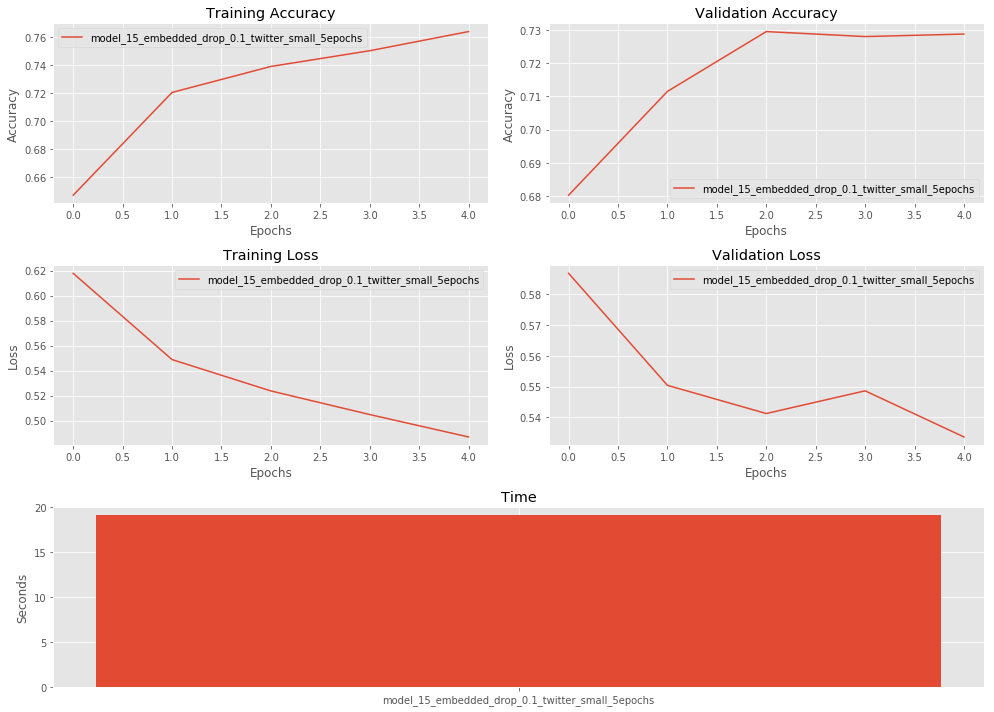

In [22]:

plt.style.use('ggplot')
plt.figure(figsize=(14, 10))#, dpi=100)

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.set_title('Training Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.set_title('Training Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')

ax3 = plt.subplot2grid((3, 2), (0, 1))
ax3.set_title('Validation Accuracy')
ax3.set_ylabel('Accuracy')
ax3.set_xlabel('Epochs')

ax4 = plt.subplot2grid((3, 2), (1, 1))
ax4.set_title('Validation Loss')
ax4.set_ylabel('Loss')
ax4.set_xlabel('Epochs')

ax5 = plt.subplot2grid((3, 2), (2, 0), rowspan=1, colspan=2)
ax5.set_title('Time')
ax5.set_ylabel('Seconds')

for mode, result in zip(models, results):
    ax1.plot(result[0].epoch, result[0].history['acc'], label=mode)
    ax2.plot(result[0].epoch, result[0].history['loss'], label=mode)
    ax3.plot(result[0].epoch, result[0].history['val_acc'], label=mode)
    ax4.plot(result[0].epoch, result[0].history['val_loss'], label=mode)
    
ax1.legend()
ax2.legend()

ax3.legend()
ax4.legend()

ax5.bar(np.arange(len(results)), [x[1] for x in results], tick_label = models.keys(), align='center')

plt.tight_layout()
plt.show()